In [168]:
from bs4 import BeautifulSoup
from itertools import product as product

import cv2
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import torch

In [47]:
TRAIN_FOLDER = '/Users/rohit/Desktop/datasets/pascal_voc_2012/VOC2012'
TEST_FOLDER = '/Users/rohit/Desktop/datasets/pascal_voc_2012/VOC2012_test'

In [53]:
def parse_xml(root_folder, filename):
    """Returns the annotations in json format for easier parsing"""

    file_path = os.path.join(root_folder, 'ImageSets', 'Main', filename)

    with open(file_path) as f:
        fnames = f.readlines()

    # Remove trailing '/n'
    fnames = [f.rstrip() for f in fnames]
    
    annotations = []
    missing_annotations = 0

    for fname in fnames:
        xml_fpath = os.path.join(root_folder, 'Annotations', fname + '.xml')

        if not os.path.exists(xml_fpath):
            print(f"Could not find xml file: {xml_fpath}")
            missing_annotations += 1
            continue

        with open(xml_fpath, 'r') as xf:
            xml_file = xf.read() 

        bs_xml_file = BeautifulSoup(xml_file, 'xml') 

        annotation = {}
        annotation['filename'] = fname

        size = bs_xml_file.find('size')
        width = int(size.find('width').get_text())
        height = int(size.find('height').get_text())
        depth = int(size.find('depth').get_text())

        annotation['size'] = {
            'width': width,
            'height': height,
            'depth': depth
        }

        objects = []
        for objs in bs_xml_file.find_all('object'):
            label = objs.find('name').get_text()

            bndbox = objs.find('bndbox')
            xmin = int(bndbox.find('xmin').get_text())
            xmax = int(bndbox.find('xmax').get_text())
            ymin = int(bndbox.find('ymin').get_text())
            ymax = int(bndbox.find('ymax').get_text())

            object_json = {
                'label': label,
                'xmin': xmin,
                'xmax': xmax,
                'ymin': ymin,
                'ymax': ymax
            }

            objects.append(object_json)

        annotation['objects'] = objects
        annotations.append(annotation)

    if missing_annotations:
        print(f"Could not find {missing_annotations} / {len(fnames)} annotations")
    else:
        print(f"Processed {len(fnames)} annotations")

    return annotations

train_annotations = parse_xml(TRAIN_FOLDER, 'trainval.txt')
test_annotations = parse_xml(TEST_FOLDER, 'test.txt')

Processed 11540 annotations
Processed 5138 annotations


In [188]:
def display_opencv_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()

### tf.data Dataset object

Box 0 class: tvmonitor


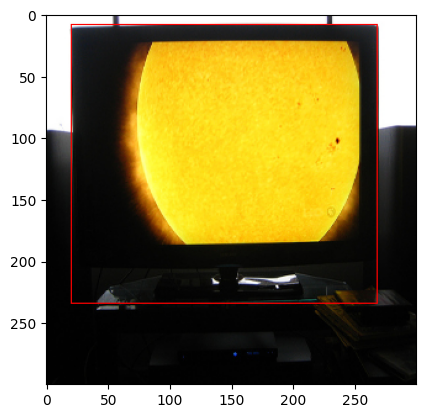

Box 0 class: train
Box 1 class: person


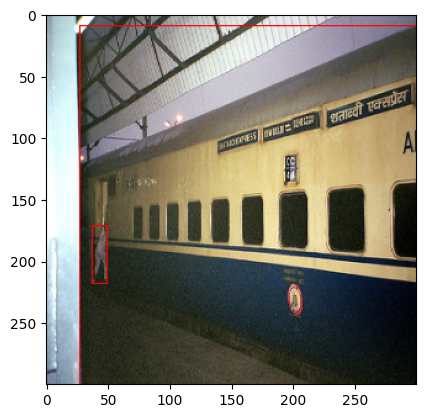

Box 0 class: boat


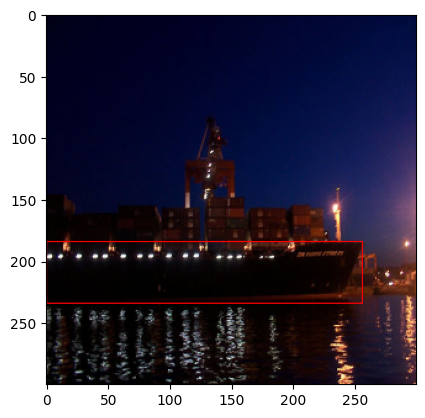

Box 0 class: horse
Box 1 class: person


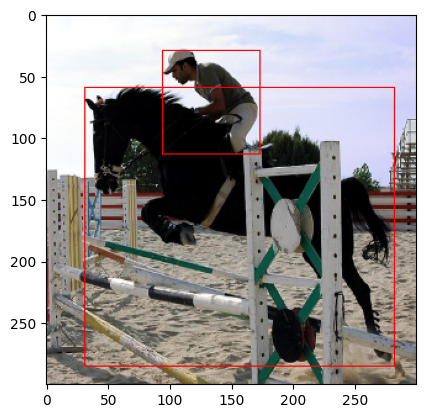

Box 0 class: cow
Box 1 class: cow


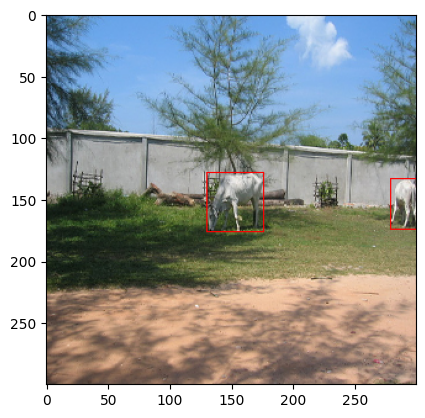

Box 0 class: bottle
Box 1 class: bottle


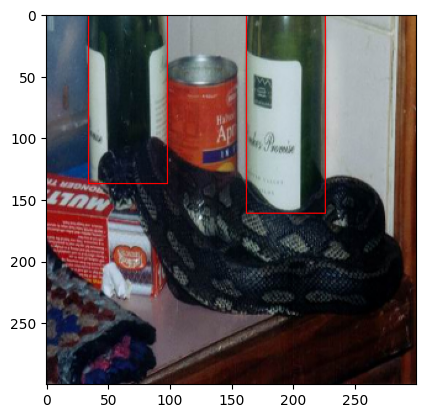

Box 0 class: tvmonitor


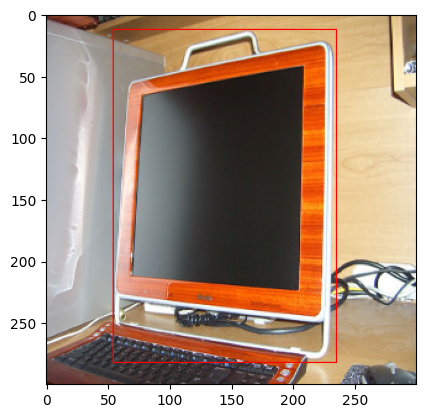

Box 0 class: dog
Box 1 class: dog
Box 2 class: dog


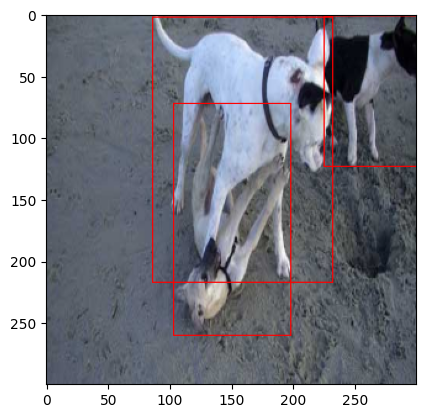

In [247]:
VOC12_CLASSES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 
                 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
                 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 
                 'sheep', 'sofa', 'train', 'tvmonitor']

class VOC12Dataset():
    def __init__(self, root_folder, filename, image_size=300) -> None:
        self.root_folder = root_folder
        self.filename = filename
        self.image_size = image_size

        file_path = os.path.join(self.root_folder, 'ImageSets', 'Main', self.filename)
        with open(file_path) as f:
            sample_names = f.readlines()

        self.sample_names = [f.rstrip() for f in sample_names]

    def _get_annotation(self, filename):
        xml_fpath = os.path.join(self.root_folder, 'Annotations', filename + '.xml')

        if not os.path.exists(xml_fpath):
            raise FileNotFoundError(f"Annotation file: {filename} does not exist")

        with open(xml_fpath, 'r') as xf:
            xml_file = xf.read() 

        bs_xml_file = BeautifulSoup(xml_file, 'xml')

        size = bs_xml_file.find('size')
        width = int(size.find('width').get_text())
        height = int(size.find('height').get_text())

        boxes = []
        for objs in bs_xml_file.find_all('object'):
            label = objs.find('name').get_text()
            label_idx = VOC12_CLASSES.index(label)

            bndbox = objs.find('bndbox')
            xmin = int(bndbox.find('xmin').get_text()) / width
            xmax = int(bndbox.find('xmax').get_text()) / width
            ymin = int(bndbox.find('ymin').get_text()) / height
            ymax = int(bndbox.find('ymax').get_text()) / height

            boxes.append([xmin, ymin, xmax, ymax, label_idx])

        return boxes

    def _get_sample(self, x):
        filename = bytes.decode(x.numpy())
        
        image_path = os.path.join(self.root_folder, 'JPEGImages', filename + '.jpg')
        image = cv2.imread(image_path)
        image = cv2.resize(image, (self.image_size, self.image_size))

        boxes = self._get_annotation(filename)
        return image, tf.ragged.constant(boxes)

    def get(self) -> tf.data.Dataset:
        dataset = tf.data.Dataset.from_tensor_slices(self.sample_names)
        dataset = dataset.map(lambda x: tf.py_function(self._get_sample, [x], [tf.uint8, tf.RaggedTensorSpec(shape=[None, 5], dtype=tf.float32)]))
        dataset = dataset.batch(8)
        return dataset

train_dataset = VOC12Dataset(TRAIN_FOLDER, 'trainval.txt')
train_dataset = train_dataset.get()

for (imgs, boxes) in train_dataset.take(1):
    batch_size = imgs.shape[0]
    for x in range(batch_size):
        image = imgs[x].numpy()
        num_boxes = boxes[x].shape[0]
        for i in range(num_boxes):
            box = tf.cast(boxes[x][i][:4] * 300, dtype=tf.int16).numpy()
            class_idx = tf.cast(boxes[x][i][4], dtype=tf.int16).numpy()
            print(f"Box {i} class: {VOC12_CLASSES[class_idx]}")
            cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 0, 255))

        display_opencv_image(image)

{'filename': '2009_000858', 'size': {'width': 500, 'height': 375, 'depth': 3}, 'objects': [{'label': 'motorbike', 'xmin': 94, 'xmax': 484, 'ymin': 115, 'ymax': 375}, {'label': 'motorbike', 'xmin': 54, 'xmax': 320, 'ymin': 74, 'ymax': 283}, {'label': 'motorbike', 'xmin': 1, 'xmax': 57, 'ymin': 81, 'ymax': 177}, {'label': 'person', 'xmin': 365, 'xmax': 427, 'ymin': 1, 'ymax': 147}, {'label': 'person', 'xmin': 438, 'xmax': 496, 'ymin': 1, 'ymax': 162}, {'label': 'person', 'xmin': 463, 'xmax': 500, 'ymin': 3, 'ymax': 220}, {'label': 'person', 'xmin': 227, 'xmax': 269, 'ymin': 1, 'ymax': 74}, {'label': 'motorbike', 'xmin': 315, 'xmax': 344, 'ymin': 8, 'ymax': 44}, {'label': 'motorbike', 'xmin': 274, 'xmax': 314, 'ymin': 4, 'ymax': 38}, {'label': 'motorbike', 'xmin': 12, 'xmax': 51, 'ymin': 23, 'ymax': 68}]}


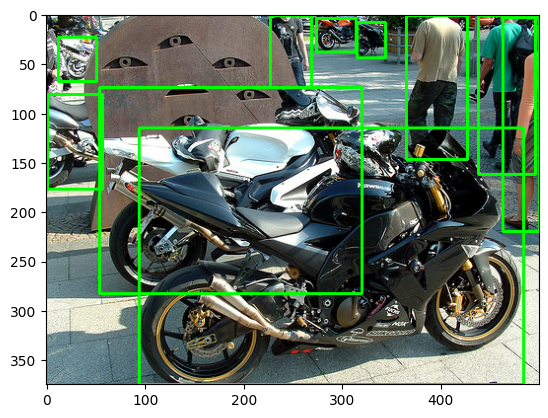

{'filename': '2009_002669', 'size': {'width': 500, 'height': 375, 'depth': 3}, 'objects': [{'label': 'train', 'xmin': 1, 'xmax': 248, 'ymin': 94, 'ymax': 182}, {'label': 'train', 'xmin': 198, 'xmax': 311, 'ymin': 98, 'ymax': 187}, {'label': 'pottedplant', 'xmin': 28, 'xmax': 61, 'ymin': 84, 'ymax': 137}, {'label': 'train', 'xmin': 287, 'xmax': 500, 'ymin': 106, 'ymax': 149}, {'label': 'pottedplant', 'xmin': 469, 'xmax': 486, 'ymin': 98, 'ymax': 125}, {'label': 'person', 'xmin': 89, 'xmax': 117, 'ymin': 124, 'ymax': 193}, {'label': 'person', 'xmin': 59, 'xmax': 77, 'ymin': 130, 'ymax': 172}, {'label': 'person', 'xmin': 447, 'xmax': 470, 'ymin': 117, 'ymax': 165}, {'label': 'person', 'xmin': 388, 'xmax': 400, 'ymin': 118, 'ymax': 144}, {'label': 'person', 'xmin': 417, 'xmax': 428, 'ymin': 116, 'ymax': 144}]}


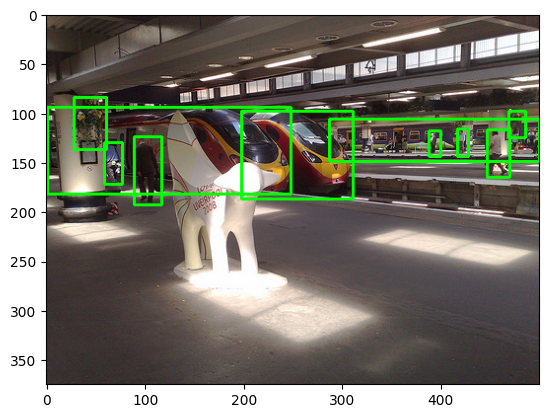

{'filename': '2011_001337', 'size': {'width': 500, 'height': 334, 'depth': 3}, 'objects': [{'label': 'train', 'xmin': 2, 'xmax': 204, 'ymin': 25, 'ymax': 334}, {'label': 'person', 'xmin': 186, 'xmax': 207, 'ymin': 211, 'ymax': 264}, {'label': 'person', 'xmin': 204, 'xmax': 214, 'ymin': 211, 'ymax': 237}, {'label': 'person', 'xmin': 215, 'xmax': 229, 'ymin': 208, 'ymax': 239}, {'label': 'person', 'xmin': 229, 'xmax': 242, 'ymin': 209, 'ymax': 241}, {'label': 'person', 'xmin': 267, 'xmax': 280, 'ymin': 217, 'ymax': 237}, {'label': 'person', 'xmin': 264, 'xmax': 271, 'ymin': 208, 'ymax': 227}, {'label': 'person', 'xmin': 424, 'xmax': 437, 'ymin': 212, 'ymax': 263}, {'label': 'train', 'xmin': 263, 'xmax': 297, 'ymin': 203, 'ymax': 222}, {'label': 'train', 'xmin': 324, 'xmax': 482, 'ymin': 171, 'ymax': 254}]}


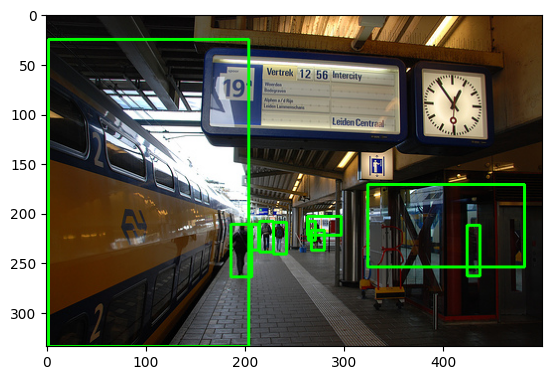

{'filename': '2010_004160', 'size': {'width': 500, 'height': 375, 'depth': 3}, 'objects': [{'label': 'person', 'xmin': 211, 'xmax': 249, 'ymin': 118, 'ymax': 207}, {'label': 'horse', 'xmin': 255, 'xmax': 366, 'ymin': 127, 'ymax': 231}, {'label': 'horse', 'xmin': 324, 'xmax': 488, 'ymin': 117, 'ymax': 248}, {'label': 'person', 'xmin': 287, 'xmax': 318, 'ymin': 90, 'ymax': 153}, {'label': 'car', 'xmin': 1, 'xmax': 101, 'ymin': 112, 'ymax': 177}, {'label': 'horse', 'xmin': 211, 'xmax': 254, 'ymin': 120, 'ymax': 142}, {'label': 'person', 'xmin': 193, 'xmax': 206, 'ymin': 109, 'ymax': 126}, {'label': 'person', 'xmin': 177, 'xmax': 188, 'ymin': 109, 'ymax': 123}, {'label': 'person', 'xmin': 430, 'xmax': 447, 'ymin': 112, 'ymax': 138}]}


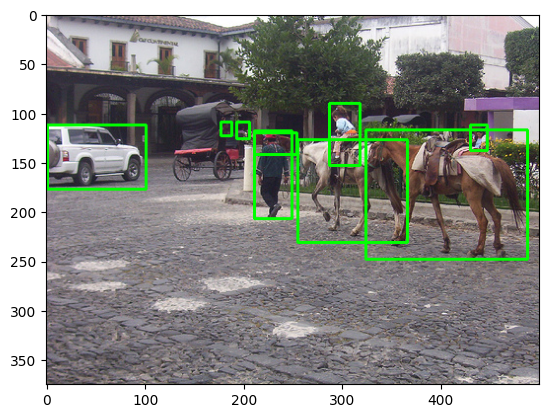

{'filename': '2009_002532', 'size': {'width': 500, 'height': 375, 'depth': 3}, 'objects': [{'label': 'car', 'xmin': 47, 'xmax': 70, 'ymin': 249, 'ymax': 272}, {'label': 'bus', 'xmin': 70, 'xmax': 357, 'ymin': 118, 'ymax': 317}]}


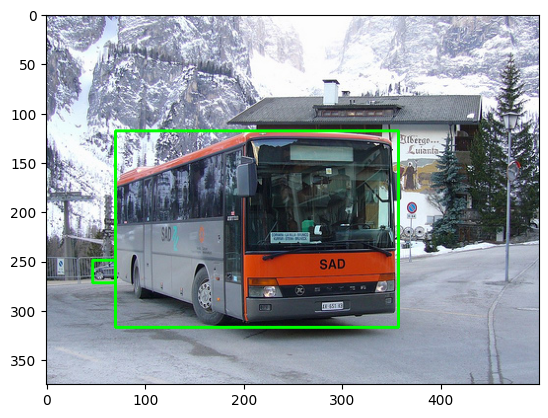

In [90]:
random.shuffle(train_annotations)

for train_annotation in train_annotations[:5]:
    filename = train_annotation['filename']

    image_path = os.path.join(TRAIN_FOLDER, 'JPEGImages', filename + '.jpg')
    image = cv2.imread(image_path)

    for obj in train_annotation['objects']:
        cv2.rectangle(image, 
        (obj['xmin'], obj['ymin']), 
        (obj['xmax'], obj['ymax']),
        (0, 255, 0), 2)

    print(train_annotation)
    display_opencv_image(image)


Scales: [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]
Feature size: 38, scale: 7.894736842105263
150 150 135 135 165 165
150 150 129 129 171 171
150 150 129 140 171 160
150 150 140 129 160 171


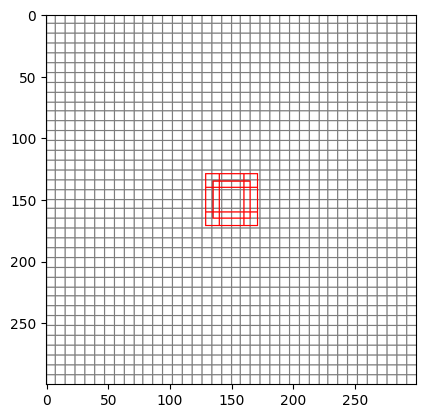

Feature size: 19, scale: 15.789473684210526
150 150 120 120 180 180
150 150 110 110 190 190
150 150 108 129 192 171
150 150 99 133 201 167
150 150 129 108 171 192
150 150 133 99 167 201


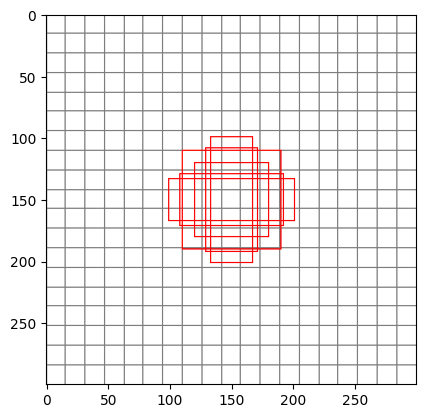

Feature size: 10, scale: 30.0
150 150 95 95 205 205
150 150 83 83 217 217
150 150 72 111 228 189
150 150 54 118 246 182
150 150 111 72 189 228
150 150 118 54 182 246


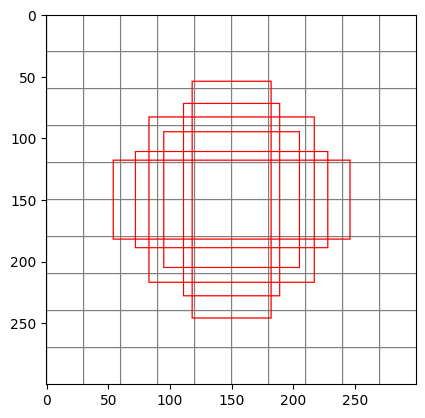

Feature size: 5, scale: 60.0
150 150 69 69 231 231
150 150 58 58 242 242
150 150 36 93 264 207
150 150 10 104 290 196
150 150 93 36 207 264
150 150 104 10 196 290


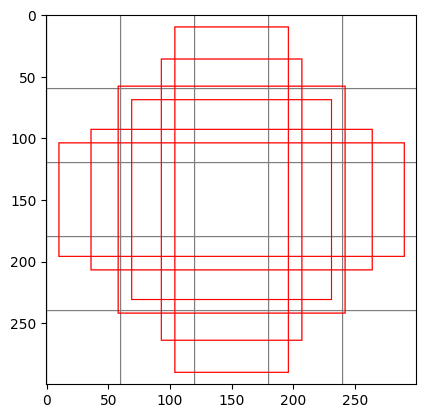

Feature size: 3, scale: 100.0
150 150 44 44 256 256
150 150 32 32 268 268
150 150 0 75 300 225
150 150 75 0 225 300


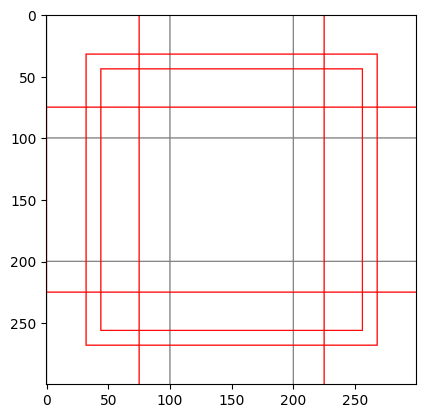

Feature size: 1, scale: 300.0
150 150 18 18 282 282
150 150 6 6 294 294
150 150 0 57 300 243
150 150 57 0 243 300


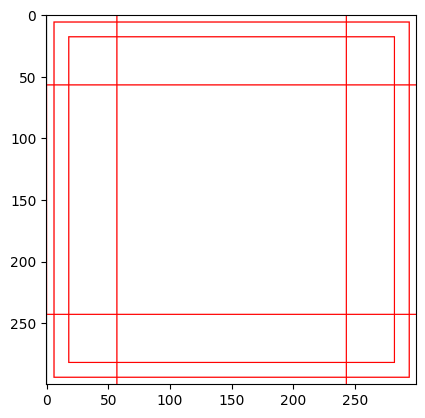

In [167]:
def get_scale_values(smin=0.1, smax=0.9, num_scales=7):
    scales = []
    for x in range(1, num_scales+1):
        sk = smin + (smax - smin) * (x - 1) / (num_scales - 1)
        scales.append(round(sk, 2))
    
    return scales

# Additional scale for last feature map (1.04)
# scales = [0.1, 0.2, 0.34, 0.48, 0.62, 0.76, 0.9]

# From the caffe implementation
scales = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]

# scales = get_scale_values()
print(f"Scales: {scales}")

aspect_ratios = [[2, 1/2],
                 [2, 3, 1/2, 1/3],
                 [2, 3, 1/2, 1/3],
                 [2, 3, 1/2, 1/3],
                 [2, 1/2],
                 [2, 1/2]]

feature_maps = [38, 19, 10, 5, 3, 1]

class DefaultBoxes():
    def __init__(self, scales, aspect_ratios, feature_maps) -> None:
        self.image_size = 300
        self.scales = scales
        self.aspect_ratios = aspect_ratios
        self.feature_maps = feature_maps

    def draw_boxes(self, ):
        all_boxes = self.list_all_boxes()

        for i, f in enumerate(self.feature_maps):
            boxes = all_boxes[i]
            scale = self.image_size / f
            print(f"Feature size: {f}, scale: {scale}")

            image = np.ones((self.image_size, self.image_size, 3), dtype=np.uint8) * 255

            # draw grid
            for x in np.arange(0, self.image_size, scale):
                cv2.line(image, (int(x), 0), (int(x), 300), (125, 125, 125))
                cv2.line(image, (0, int(x)), (300, int(x)), (125, 125, 125))
            
            for box in boxes:
                w = min(int(box[1] * self.image_size), self.image_size)
                h = min(int(box[2] * self.image_size), self.image_size)

                cx, cy = self.image_size // 2, self.image_size // 2

                tlx, tly = cx - w // 2, cy - h // 2
                brx, bry = cx + w // 2, cy + h // 2

                print(cx, cy, tlx, tly, brx, bry)
                cv2.rectangle(image, (tlx, tly), (brx, bry), (255, 0, 0))

            plt.imshow(image)
            plt.show()

    def list_all_boxes(self, debug = False):
        all_boxes = []
        for i, f in enumerate(self.feature_maps):
            sk  = self.scales[i]
            sk_prime = math.sqrt(sk * self.scales[i+1])

            boxes = [[1, sk, sk], [1, sk_prime, sk_prime]]

            for ar in self.aspect_ratios[i]:
                boxes.append([ar, sk * math.sqrt(ar), sk / math.sqrt(ar)])

            if debug:
                print(f"f: {f}, sk: {sk}, sk': {sk_prime:0.2f}")
                for box in boxes:
                    print(f"ar: {box[0]:0.2f}, w: {box[1]:0.2f}, h: {box[2]:0.2f}")

            all_boxes.append(boxes)

        return all_boxes   

    def compute(self, ):
        boxes = []
        for i, f in enumerate(self.feature_maps):
            sk  = self.scales[i]
            sk_prime = math.sqrt(sk * self.scales[i+1])
            print(f"sk: {sk}, sk': {sk_prime}")
            for m, n in product(range(f), repeat=2):
                cx = (n + 0.5) / f
                cy = (m + 0.5) / f

                # Aspect ratio of 1 with sk
                boxes += [cx, cy, sk, sk]

                # Aspect ration of 1 with sqrt(sk * sk+1)
                boxes += [cx, cy, sk_prime, sk_prime]

                # Rest of the aspect ratios
                for ar in self.aspect_ratios[i]:
                    boxes += [cx, cy, sk * math.sqrt(ar), sk / math.sqrt(ar)]

        return boxes



default_boxes = DefaultBoxes(scales, aspect_ratios, feature_maps)
# boxes = default_boxes.compute()

default_boxes.draw_boxes()